In [1]:
import pandas as py
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor

df = py.read_csv(r'D:\ML\BTP\preprocessing\final_bowler.csv')
with open('bowler_encoder.pkl', 'rb') as file:
    bw = pickle.load(file)
with open('venue_encoder.pkl', 'rb') as file:
    vn = pickle.load(file)
with open('batting_team_encoder.pkl', 'rb') as file:
    bt = pickle.load(file)
df['bowler'] = bw.fit_transform(df['bowler'])
df['venue'] = vn.fit_transform(df['venue'])
df['batting_team'] = bt.fit_transform(df['batting_team'])
y = df.pop('dream 11 score')
X = df
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

parameters = {'loss_function': ['RMSE','MAE'],
                      'depth': [4, 6, 8],
                      'learning_rate': [0.01, 0.05, 0.1],
                      'iterations': [30, 100, 300, 1000],
                      'l2_leaf_reg': [.1, 1, 10, 100],
                      'early_stopping_rounds': [100],
                      'random_strength': [1],
                      'od_type': ['IncToDec'],
                      'random_seed': [1],
                      'use_best_model': [True]}


catboost_model = CatBoostRegressor()

In [2]:
cat_grid = RandomizedSearchCV(catboost_model,
                                parameters,
                                cv=4,
                                n_jobs=4)

In [3]:
cat_grid.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=100)

0:	learn: 28.6437242	test: 28.7379371	best: 28.7379371 (0)	total: 175ms	remaining: 2m 54s
1:	learn: 28.5191540	test: 28.6117305	best: 28.6117305 (1)	total: 193ms	remaining: 1m 36s
2:	learn: 28.3847305	test: 28.4748664	best: 28.4748664 (2)	total: 205ms	remaining: 1m 8s
3:	learn: 28.2516338	test: 28.3403620	best: 28.3403620 (3)	total: 217ms	remaining: 54s
4:	learn: 28.1294235	test: 28.2173075	best: 28.2173075 (4)	total: 227ms	remaining: 45.1s
5:	learn: 28.0094597	test: 28.0957818	best: 28.0957818 (5)	total: 237ms	remaining: 39.3s
6:	learn: 27.8846304	test: 27.9701889	best: 27.9701889 (6)	total: 249ms	remaining: 35.4s
7:	learn: 27.7585439	test: 27.8436865	best: 27.8436865 (7)	total: 259ms	remaining: 32.2s
8:	learn: 27.6286811	test: 27.7113585	best: 27.7113585 (8)	total: 269ms	remaining: 29.7s
9:	learn: 27.5068476	test: 27.5853733	best: 27.5853733 (9)	total: 282ms	remaining: 27.9s
10:	learn: 27.3884241	test: 27.4643969	best: 27.4643969 (10)	total: 292ms	remaining: 26.2s
11:	learn: 27.26744

RandomizedSearchCV(cv=4,
                   estimator=<catboost.core.CatBoostRegressor object at 0x000002231AD2B550>,
                   n_jobs=4,
                   param_distributions={'depth': [4, 6, 8],
                                        'early_stopping_rounds': [100],
                                        'iterations': [30, 100, 300, 1000],
                                        'l2_leaf_reg': [0.1, 1, 10, 100],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'loss_function': ['RMSE', 'MAE'],
                                        'od_type': ['IncToDec'],
                                        'random_seed': [1],
                                        'random_strength': [1],
                                        'use_best_model': [True]})

In [4]:
best_random_grid=cat_grid.best_estimator_

In [5]:
best_random_grid

In [6]:
y_pred = best_random_grid.predict(X_test)

In [7]:
y_pred

array([ 44.15340071,  58.55954757,  92.05613887, ...,  56.86739332,
       118.74375603,  23.32621279])

In [8]:
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import r2_score

In [9]:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


r2 = r2_score(y_test, y_pred)
print("r2 is:", r2)

Mean Squared Error: 595.845301975142
r2 is: 0.5321139818416153


In [10]:
pickle.dump(best_random_grid, open('cat.pkl', 'wb'))

In [11]:
import matplotlib.pyplot as plt

In [12]:
importances = best_random_grid.get_feature_importance(type='PredictionValuesChange')
feature_importances = py.Series(importances, index=X.columns).sort_values()

Text(0, 0.5, 'Features')

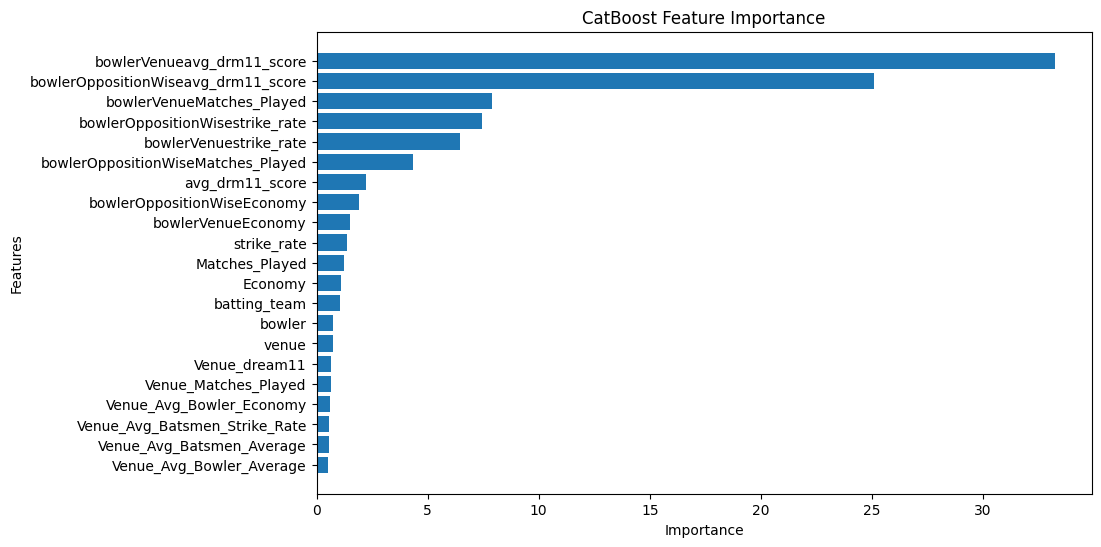

In [13]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importances.index, feature_importances.values)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')

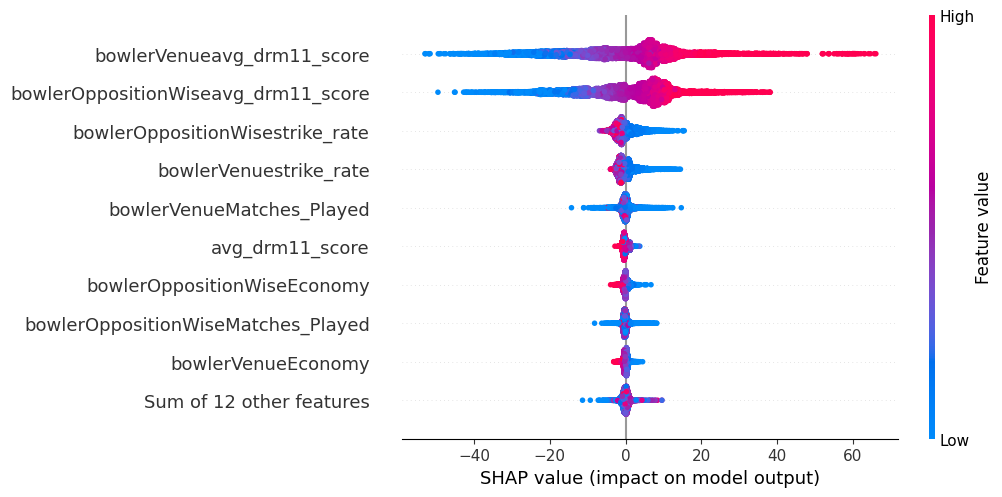

In [15]:
import shap
explainer = shap.TreeExplainer(best_random_grid)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values)